In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import xcompare as xc
import momlevel
import os

In [3]:
shlf_mask = xr.open_dataset('/work/jet/rlb_masks/CM4_1000m_Isobath_Contour_Transport_Masks.nc')\
            .contour_masked_south.rename({'xh':'x','yh':'y'}).reset_coords(drop=True)

In [4]:
platfrom = 'gfdl.ncrc4-intel18-prod-openmp'
pp = 'ocean_annual_z'
tprd = '0081-0090'
var = 'so'
yr = None # '0050' # None 

# Pick simulation/observation to compare against (only one entry allowed)
mod_ctr = 'WOA13' # CM4_piControl_c192_OM4p125_v7, CM4_piControl_C

# Pick simulation(s) to compare control
mods = ['CM4_piControl_c192_OM4p125_v7','CM4_piControl_c192_OM4p125_v6_alt1', 'CM4_piControl_C'] # ['CM4_piControl_c192_OM4p125_v6_alt1', 'CM4_piControl_C']
mods.insert(0,mod_ctr)

In [5]:
ddict = {mod:{} for mod in mods}
for mod in ddict:
    print('\n',mod)
    
    if mod not in ['WOA13','Schmidtko']:
        pp_dir = '/pp/%s/ts/annual/10yr/'%pp
        rootdir = '/home/Jan-erik.Tesdal/data/raw/%s/ocean_annual_z/'%mod if mod=='CM4_piControl_C' \
                else '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/%s/'%mod+platfrom+pp_dir \
                    if mod=='CM4_piControl_c192_OM4p25' \
                else '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/%s/'%mod+platfrom+pp_dir
        tprd_str = tprd[:3]+'*' if mod=='CM4_piControl_C' else tprd
        data_path = rootdir+pp+'.'+tprd_str+'.'+var+'.nc'
        print(data_path)
    elif mod=='WOA13':
        data_path = '/archive/gold/datasets/obs/WOA13/WOA13_ptemp+salinity_annual_35levels.nc'
        print(data_path)

    vars_ds = xr.open_mfdataset(data_path,use_cftime=True) if mod not in ['WOA13','Schmidtko'] else xr.open_dataset(data_path,decode_times=False)
    print(str(vars_ds.time.values[0])[:10],'to',str(vars_ds.time.values[-1])[:10])
    
    if mod not in ['WOA13','Schmidtko']:
        grid_path = os.path.sep.join(rootdir.split(os.path.sep)[:-2])+'/ocean_monthly/ocean_monthly.static.nc' \
                        if mod=='CM4_piControl_C' \
                    else os.path.sep.join(rootdir.split(os.path.sep)[:-4])+'/'+pp+'.static.nc'
        #print(grid_path)
        grid_ds = xr.open_dataset(grid_path,use_cftime=True)
        #print(grid_ds)
        if yr is None:
            print('Calculate temporal mean')
            arr = vars_ds[var].isel(z_l=0).mean('time')
        else:
            arr = vars_ds[var].isel(z_l=0).sel(time=yr).squeeze()
        arr = xc.coord_util.associate_ocean_coords(arr,grid_ds)
        
    elif mod=='WOA13':
        arr = vars_ds.salinity.isel(z_l=0).squeeze().rename(var)
        
    ddict[mod] = arr.to_dataset()


 WOA13
/archive/gold/datasets/obs/WOA13/WOA13_ptemp+salinity_annual_35levels.nc
6.0 to 6.0

 CM4_piControl_c192_OM4p125_v7
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/ocean_annual_z.0081-0090.so.nc
0081-07-02 to 0090-07-02
Calculate temporal mean

 CM4_piControl_c192_OM4p125_v6_alt1
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/ocean_annual_z.0081-0090.so.nc
0081-07-02 to 0090-07-02
Calculate temporal mean

 CM4_piControl_C
/home/Jan-erik.Tesdal/data/raw/CM4_piControl_C/ocean_annual_z/ocean_annual_z.008*.so.nc
0081-07-02 to 0090-07-02
Calculate temporal mean


In [6]:
ddict_diff = {mod:{} for mod in list(ddict)[1:]}
for mod in ddict_diff:
    print(mod)
    ddict_diff[mod] = xc.compare_datasets(ddict[mod_ctr],ddict[mod],varlist=[var])

CM4_piControl_c192_OM4p125_v7
CM4_piControl_c192_OM4p125_v6_alt1
CM4_piControl_C


In [7]:
import cartopy
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from plot import get_so_map_boundary
circle = get_so_map_boundary()

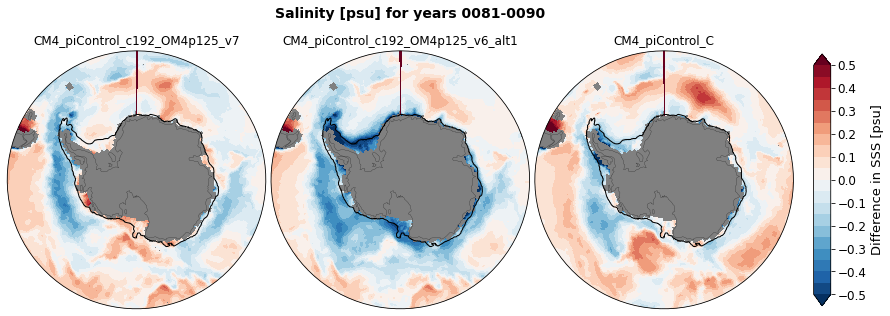

In [9]:
titel_str = titel_str = 'Salinity [psu] for years %s'%(tprd if yr is None else yr)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), 
                         subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                         facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

for i, mod in enumerate(ddict_diff):
    
    da = ddict_diff[mod]['diff'][var]*(-1) # map differences as mod minus obs
    
    axes[i].coastlines(lw=0.2)
    axes[i].set_extent([-300, 60, -50, -90], cartopy.crs.PlateCarree())
    axes[i].set_boundary(circle, transform=axes[i].transAxes)
    p = da.plot(ax=axes[i], x='lon', y='lat', cmap='RdBu_r', vmin=-0.5, vmax=0.5, shading='auto',levels=21, extend='both',
                transform=cartopy.crs.PlateCarree(), add_colorbar=False)
    
    cs = shlf_mask.fillna(0).plot.contour(ax=axes[i], x='x', y='y', linewidths=1, colors='k',transform=cartopy.crs.PlateCarree(), 
                                          add_labels=False,levels=[0,1,2])
    
    axes[i].set_title(mod, fontsize=12)
    
fig.suptitle(titel_str,fontweight='bold',fontsize=14,y=0.98)
cax = fig.add_axes([0.9, 0.15 , 0.017, 0.7])
cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=np.arange(-0.5,0.6,0.1), shrink=0.5, pad=0.2)
cb.set_label(r'Difference in SSS [psu]', fontsize=13)
cb.ax.tick_params(labelsize=12)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

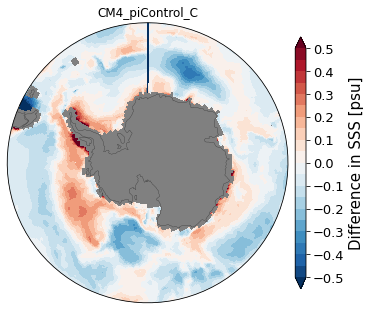

In [10]:
da = ddict_diff[mod]['diff'][var]
fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.coastlines(lw=0.2)
ax.set_extent([-300, 60, -50, -90], cartopy.crs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

p =  da.plot(ax=ax, x='lon', y='lat', cmap='RdBu_r', vmin=-0.5, vmax=0.5, shading='auto', levels=21, extend='both',
             transform=cartopy.crs.PlateCarree(), add_colorbar=False)
cs = shlf_mask.fillna(0).plot.contour(ax=axes[i], x='x', y='y', linewidths=1, colors='k',transform=cartopy.crs.PlateCarree(), 
                                          add_labels=False,levels=[0,1,2])
ax.set_title(mod, fontsize=12)

# Add separate colorbar
cax = fig.add_axes([0.9, 0.15 , 0.03, 0.7])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-0.5,0.6,0.1), orientation='vertical', shrink=0.9, pad=0.02)
cb.set_label(r'Difference in SSS [psu]', fontsize=15)
cb.ax.tick_params(labelsize=13)

#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

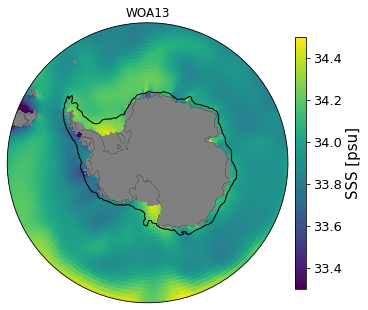

In [14]:
da = ddict[mod_ctr].so

fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.coastlines(lw=0.2)
ax.set_extent([-300, 60, -50, -90], cartopy.crs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

p =  da.plot(ax=ax, x='lon', y='lat', vmin=33.3, vmax=34.5, cmap='viridis', shading='auto', 
             transform=cartopy.crs.PlateCarree(), add_colorbar=False)
cs = shlf_mask.fillna(0).plot.contour(ax=ax, x='x', y='y', linewidths=1, colors='k',transform=cartopy.crs.PlateCarree(), 
                                      add_labels=False,levels=[0,1,2])

ax.set_title(mod_ctr, fontsize=12)

# Add separate colorbar
cax = fig.add_axes([0.9, 0.15 , 0.03, 0.7])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(33.4,34.6,0.2), orientation='vertical', shrink=0.9, pad=0.02)
cb.set_label(r'SSS [psu]', fontsize=15)
cb.ax.tick_params(labelsize=13)

#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

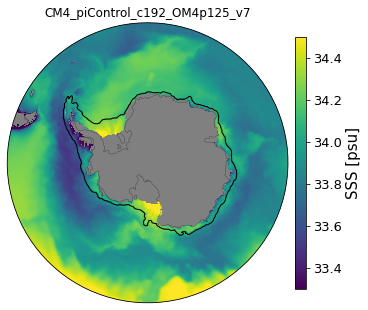

In [15]:
mod = 'CM4_piControl_c192_OM4p125_v7'
da = ddict[mod].so

fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

ax = plt.axes(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey')
ax.coastlines(lw=0.2)
ax.set_extent([-300, 60, -50, -90], cartopy.crs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

p =  da.where(da.wet==1).plot(ax=ax, x='geolon', y='geolat', vmin=33.3, vmax=34.5, cmap='viridis', shading='auto', 
                              transform=cartopy.crs.PlateCarree(), add_colorbar=False)
cs = shlf_mask.fillna(0).plot.contour(ax=ax, x='x', y='y', linewidths=1, colors='k',transform=cartopy.crs.PlateCarree(), 
                                      add_labels=False,levels=[0,1,2])

ax.set_title(mod, fontsize=12)

# Add separate colorbar
cax = fig.add_axes([0.9, 0.15 , 0.03, 0.7])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(33.4,34.6,0.2), orientation='vertical', shrink=0.9, pad=0.02)
cb.set_label(r'SSS [psu]', fontsize=15)
cb.ax.tick_params(labelsize=13)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Two-panel figure

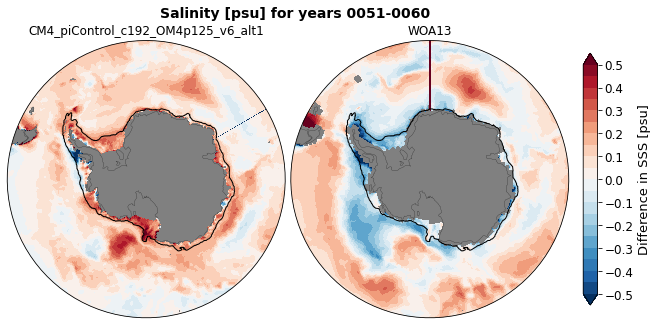

In [9]:
titel_str = titel_str = 'Salinity [psu] for years %s'%(tprd if yr is None else yr)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), 
                         subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                         facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

for i, mod in enumerate(ddict_diff):
    
    da = ddict_diff[mod]['diff'][var]
    
    axes[i].coastlines(lw=0.2)
    axes[i].set_extent([-300, 60, -50, -90], cartopy.crs.PlateCarree())
    axes[i].set_boundary(circle, transform=axes[i].transAxes)
    p = da.plot(ax=axes[i], x='lon', y='lat', cmap='RdBu_r', vmin=-0.5, vmax=0.5, shading='auto',levels=21, extend='both',
                transform=cartopy.crs.PlateCarree(), add_colorbar=False)
    cs = shlf_mask.fillna(0).plot.contour(ax=axes[i], x='x', y='y', linewidths=1, colors='k',transform=cartopy.crs.PlateCarree(), 
                                          add_labels=False,levels=[0,1,2])
    axes[i].set_title(mod, fontsize=12)
    
fig.suptitle(titel_str,fontweight='bold',fontsize=14,y=0.98)
cax = fig.add_axes([0.9, 0.15 , 0.02, 0.7])
cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=np.arange(-0.5,0.6,0.1), shrink=0.5, pad=0.2)
cb.set_label(r'Difference in SSS [psu]', fontsize=13)
cb.ax.tick_params(labelsize=12)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

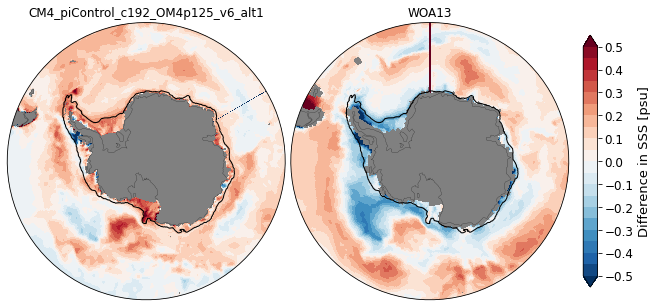

In [15]:
titel_str = titel_str = 'Salinity [psu] for years %s'%(tprd if yr is None else yr)
labels = [mod_ctr, mod]
vrange_var,vrange_dif = [33.21, 34.58],[-0.61, 0.61]
cmap_var,cmap_dif = 'viridis','RdBu_r'
set_vrange = True

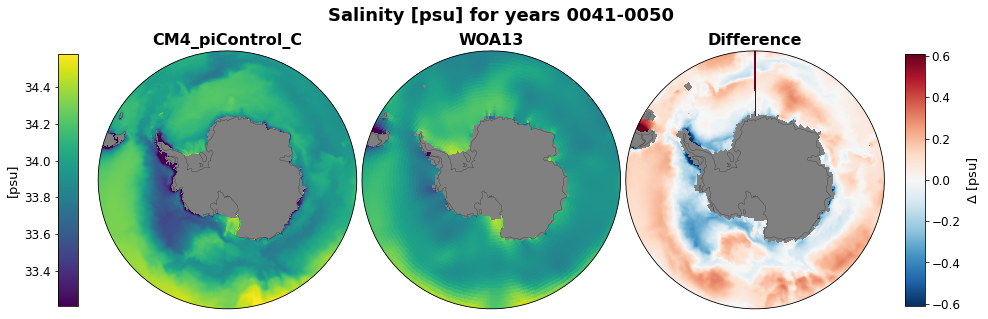

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), 
                         subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                         facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.01, wspace=0.02)

for i, arr_name in enumerate(['ds1_orig','ds2_orig','diff']):
    
    da = ddict_diff[mod][arr_name][var]
    
    axes[i].coastlines(lw=0.2)
    axes[i].set_extent([-300, 60, -50, -90], cartopy.crs.PlateCarree())
    axes[i].set_boundary(circle, transform=axes[i].transAxes)
    
    if set_vrange:
        vrange = vrange_dif if arr_name=='diff' else vrange_var
        robust=False
    else:
        vrange = [None, None]
        robust=True
        
    cmap = cmap_dif if arr_name=='diff' else cmap_var
    
    p = da.plot(ax=axes[i], x='lon', y='lat', cmap=cmap, robust=robust, vmin=vrange[0], vmax=vrange[1], shading='auto',
                transform=cartopy.crs.PlateCarree(), add_colorbar=False)
    
    axes[i].set_title(labels[i] if i<2 else 'Difference',fontsize=16, fontweight='bold')
    
    if i==0:
        cax = fig.add_axes([0.06, 0.15 , 0.02, 0.7])
        cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.5, pad=0.2)
        cb.set_label('[psu]', fontsize=13)
        cb.ax.tick_params(labelsize=12)
        cax.yaxis.set_ticks_position('left')
        cax.yaxis.set_label_position('left')
    elif i==2:
        cax = fig.add_axes([0.9, 0.15 , 0.02, 0.7])
        cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.5, pad=0.2)
        cb.set_label('$\Delta$ [psu]', fontsize=13)
        cb.ax.tick_params(labelsize=12)

fig.suptitle(titel_str,fontweight='bold',fontsize=18,y=0.98)
plt.show()

In [69]:
grid = xr.open_dataset('/home/Jan-erik.Tesdal/data/raw/CM4_piControl_C/ocean_monthly/ocean_monthly.static.nc',use_cftime=True)
so_woa = xr.DataArray(ddict_diff[mod]['ds2'].so.values,coords=[grid.yh.values,grid.xh.values], dims=['y','x'])

In [79]:
ds_woa = so_woa.to_dataset(name='so')
ds_woa['areacello'] = grid.areacello.rename({'xh':'x','yh':'y'})
ds_woa['wet'] = grid.wet.rename({'xh':'x','yh':'y'})

In [81]:
ds_woa_onshlf = ds_woa.where(shlf_mask==1,drop=True)

In [82]:
so_woa_onshlf = ds_woa_onshlf.so.where(ds_woa_onshlf.so > 0)

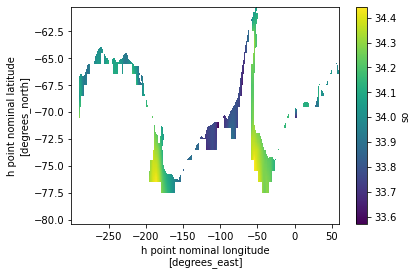

In [84]:
so_woa_onshlf.plot()

In [88]:
from compute import horizontal_mean

In [92]:
print('SSS over the shelf:',horizontal_mean(so_woa_onshlf,ds_woa_onshlf).values)

SSS over the shelf: 34.076182988906744


## Testing with single comparison

In [9]:
pp = 'ocean_annual_z'
tprd = '0041-0050'
var = 'so'
yr = '0050' # None 
# Odiv-209, Odiv-207, Odiv-206, Odiv-200, Odiv-191, Odiv-184
rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/' 

subdir1 = 'CM4_piControl_c192_OM4p125_v7' # Odiv-209
#subdir2 = 'CM4_piControl_c192_OM4p125_v6_alt1' # Odiv-200

platfrom = 'gfdl.ncrc4-intel18-prod-openmp'
data_path1 = os.path.join(rootdir,subdir1,platfrom,'pp',pp)+'/ts/annual/10yr/'+pp+'.'+tprd+'.'+var+'.nc'
grid_path1 = os.path.join(rootdir,subdir1,platfrom,'pp',pp)+'/'+pp+'.static.nc'
ds1 = xr.open_dataset(data_path1,use_cftime=True)
ds1_grid = xr.open_dataset(grid_path1,use_cftime=True)

#data_path2 = os.path.join(rootdir,subdir2,platfrom,'pp',pp)+'/ts/annual/10yr/'+pp+'.'+tprd+'.'+var+'.nc'
#grid_path2 = os.path.join(rootdir,subdir2,platfrom,'pp',pp)+'/'+pp+'.static.nc'
#ds2 = xr.open_dataset(data_path2,use_cftime=True)
#ds2_grid = xr.open_dataset(grid_path2,use_cftime=True)

data_path = '/archive/gold/datasets/obs/WOA13/WOA13_ptemp+salinity_annual_35levels.nc'
print(data_path)
vars_ds = xr.open_dataset(data_path,decode_times=False)

/archive/gold/datasets/obs/WOA13/WOA13_ptemp+salinity_annual_35levels.nc


In [10]:
print(str(vars_ds.time.values[0])[:10],'to',str(vars_ds.time.values[-1])[:10])

6.0 to 6.0


In [8]:
arr1 = ds1[var].isel(z_l=0).mean('time')
arr1 = xc.coord_util.associate_ocean_coords(arr1,ds1_grid)

In [9]:
#arr2 = ds2[var].isel(z_l=0).sel(time=yr).squeeze()
arr2 = ds2.salinity.isel(z_l=0).squeeze().rename(var)

In [11]:
ds1 = arr1.to_dataset()
ds2 = arr2.to_dataset()

In [15]:
results= xc.compare_datasets(ds1,ds2,varlist=[var])

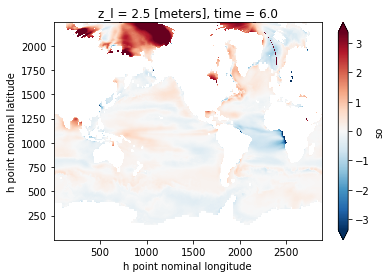

In [19]:
results['diff'].so.plot(robust=True)

In [11]:
if yr is None:
    arr1 = ds1[var].isel(z_l=0).mean('time')
    arr2 = ds2[var].isel(z_l=0).mean('time')
else:
    arr1 = ds1[var].isel(z_l=0).sel(time=yr).squeeze()
    arr2 = ds2[var].isel(z_l=0).sel(time=yr).squeeze()
    
    
arr1 = xc.coord_util.associate_ocean_coords(arr1,ds1_grid)
arr2 = xc.coord_util.associate_ocean_coords(arr2,ds2_grid)

ds1 = arr1.to_dataset()
ds2 = arr2.to_dataset()

In [32]:
from xcompare import plot_three_panel

In [10]:
fig = plot_three_panel(results,var,coastlines=False,lat_range=(-90,-45),projection=cartopy.crs.SouthPolarStereo())

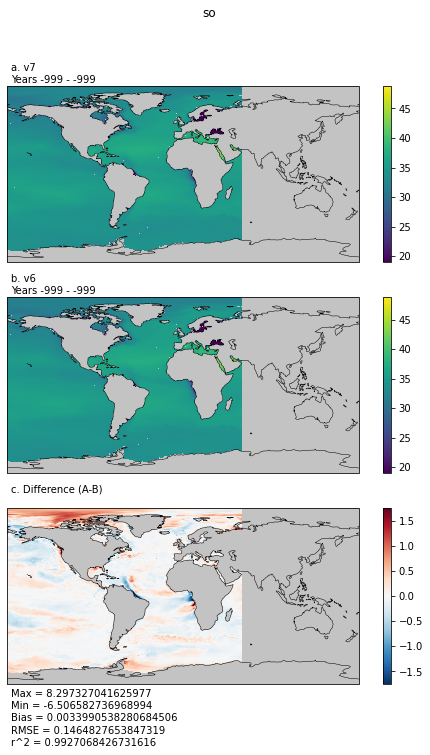

In [12]:
labels = ["v7", "v6"]
fig = plot_three_panel(results, var, labels=labels, sigma=5)

/nbhome/jet/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/jet/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/nbhome/jet/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/nbhome/jet/miniconda3/envs/pyt

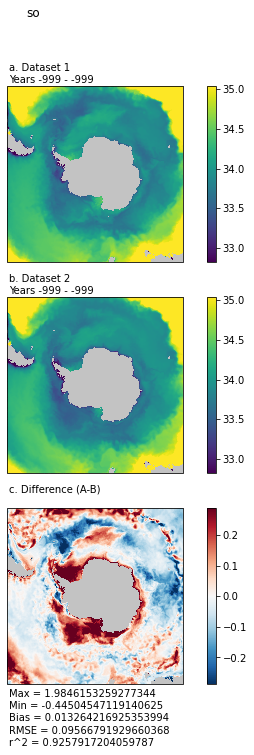

In [33]:
fig = plot_three_panel(results,var,coastlines=False,lat_range=(-90,-45),projection=cartopy.crs.SouthPolarStereo())

In [35]:
results = xc.Compare(arr1,arr2,verbose=True)

Performing Comparison on Arrays


In [37]:
print(results.difference.attrs)

{'bias': 0.0033990538280684506, 'rmse': 0.1464827653847319, 'rsquared': 0.9927068426731616}


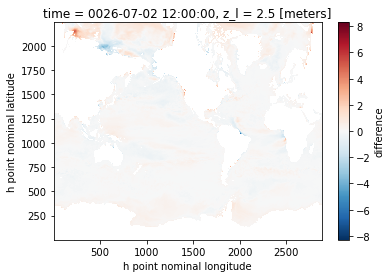

In [38]:
results.difference.plot()